In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
from torchvision import datasets, transforms

transform=transforms.Compose([transforms.ToTensor()])

data_train = datasets.MNIST('/Users/kosio/Data/MNIST/', train=True, transform=transform, download=True)
data_test = datasets.MNIST('/Users/kosio/Data/MNIST/', train=False, transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)


/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <632A2621-54FC-39C2-963C-47795485AE07> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#output before training
layer_sizes = [2000,1000,500,100]


model = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=layer_sizes, out_layer_sz=10, init_type='none',
                          mean = 0, std=0.01)

test_samples = np.random.choice(np.arange(0,10000),size=1000,replace=False)
test_dat = data_test.data.reshape(len(data_test.data),-1).float()[test_samples]
out_code = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(test_dat):
    out_code[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)
out = model(data_test.data.reshape(len(data_test.data),-1).float())


0
100
200
300
400
500
600
700
800
900


In [4]:
rand_samples = 255*torch.randn(test_dat.shape)#255*torch.rand(test_dat.shape)#

out_code_pre_rand = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(rand_samples):
    out_code_pre_rand[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)


0
100
200
300
400
500
600
700
800
900


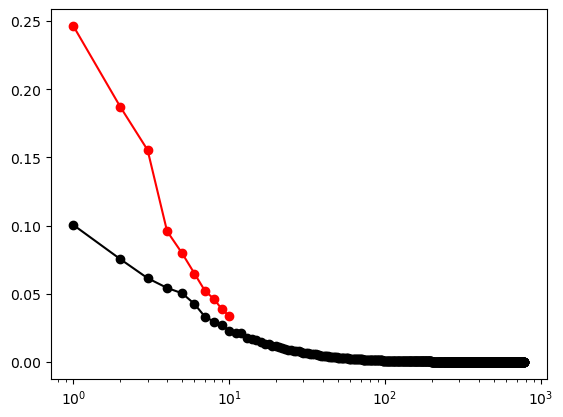

In [5]:
#show the PCA spectrum of the MNIST data
from sklearn.decomposition import PCA
reduced_MNIST = PCA().fit(data_test.data.reshape(len(data_test.data),-1).float())
reduced_output = PCA().fit(out[-1].detach().numpy())

plt.plot(np.arange(1,785),reduced_MNIST.explained_variance_ratio_,'k-o')
plt.plot(np.arange(1,len(reduced_output.explained_variance_ratio_)+1),reduced_output.explained_variance_ratio_,'r-o')
plt.xscale('log')

In [6]:
#Train
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
n_test_samples = 1000

min_ranks_epochs = np.zeros(n_epochs)
mean_ranks_epochs = np.zeros(n_epochs)
generalization_error = np.zeros(n_epochs)

# Define the training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=n_epochs):
    model.train()  # Set the model to training mode
    for epoch in tqdm(range((num_epochs))):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs.reshape(len(inputs),-1))[-1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        out_code_temp = np.zeros([n_test_samples])
        temp_samples = np.random.choice(np.arange(0,10000),size=n_test_samples,replace=False)
        temp_dat = data_test.data.reshape(len(data_test.data),-1).float()[temp_samples]
        for i, x_i in enumerate(temp_dat):
            out_code_temp[i] = model.compute_rank_at_point(x_i)[-2]
        min_ranks_epochs[epoch] = np.min(out_code_temp)
        mean_ranks_epochs[epoch] = np.mean(out_code_temp)
        generalization_error[epoch] = running_loss/len(trainloader)

            
        if epoch % 50 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

# Train the model
train_model(model, trainloader, criterion, optimizer)


  2%|▉                                                | 1/50 [02:05<1:42:53, 126.00s/it]

[1,  1000] loss: 0.444


100%|████████████████████████████████████████████████| 50/50 [1:45:18<00:00, 126.37s/it]


In [7]:
#Calculate test performance
out_test = torch.argmax(model(data_test.data.float().reshape(len(data_test.data),-1))[-1],1)
print((torch.sum(out_test==data_test.targets)/len(out_test)).item())

0.9842000007629395


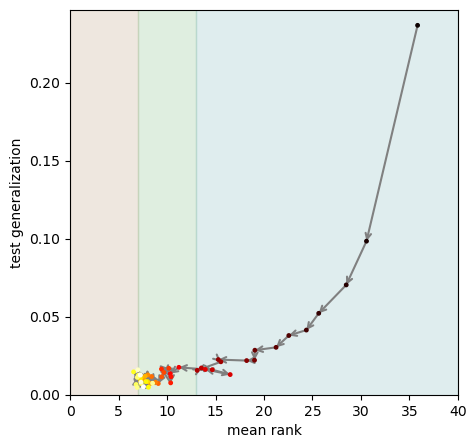

In [16]:
fig = plt.figure(figsize=(5,5))
#plt.scatter(np.arange(0,n_epochs),min_ranks_epochs,c=generalization_error,cmap='hot',vmax=100,vmin=0)

#plt.plot(mean_ranks_epochs, generalization_error/len(trainloader),color='k')
#plt.scatter(mean_ranks_epochs, generalization_error/len(trainloader),c=np.arange(0,n_epochs),cmap='hot',zorder=1000)
#plt.plot(mean_ranks_epochs, generalization_error,color='k',lw=3,alpha=1)
#for i in range(len(min_ranks_epochs) - 1):
#    plt.annotate('', xy=(min_ranks_epochs[i+1], generalization_error[i+1]), xytext=(min_ranks_epochs[i], generalization_error[i]),
#                 arrowprops=dict(facecolor='black', lw=1.5,arrowstyle='->', shrinkA=1000, shrinkB=0),)
for i in range(len(mean_ranks_epochs) - 1):
    plt.annotate('', xy=(mean_ranks_epochs[i+1], generalization_error[i+1]), xytext=(mean_ranks_epochs[i], generalization_error[i]),
                 arrowprops=dict(edgecolor='gray', lw=1.5,arrowstyle='->', shrinkA=1000, shrinkB=0),)

plt.fill_betweenx([-1,2*max(generalization_error)],[0,0],[7,7],color='#c7b195ff',alpha=0.3)
plt.fill_betweenx([-1,2*max(generalization_error)],[7,7],[13,13],color='#95c79aff',alpha=0.3)
plt.fill_betweenx([-1,2*max(generalization_error)],[13,13],[40,40],color='#95c6c7ff',alpha=0.3)
plt.scatter(mean_ranks_epochs, generalization_error,c=np.arange(0,n_epochs),cmap='hot',zorder=1000,s=6)
plt.ylim([0,max(generalization_error)+0.01])
plt.xlim([0,40])
plt.xlabel('mean rank',fontsize=10)
plt.ylabel('test generalization')
#plt.yscale('log')
plt.savefig("/Users/kosio/Figures/MfldClassification/rank_generalization.png",dpi=500, transparent=True)

In [9]:
#output after training
out_code_post = np.zeros([len(test_dat),len(layer_sizes)])
for i, x_i in enumerate(test_dat):
    out_code_post[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900


In [10]:
#run model through random images to see if low ranks are placed near data samples or if in general the space is lower rank
out_code_rand = np.zeros([len(rand_samples),len(layer_sizes)])
for i, x_i in enumerate(rand_samples):
    out_code_rand[i,:] = model.compute_rank_at_point(x_i)[:-1]
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900


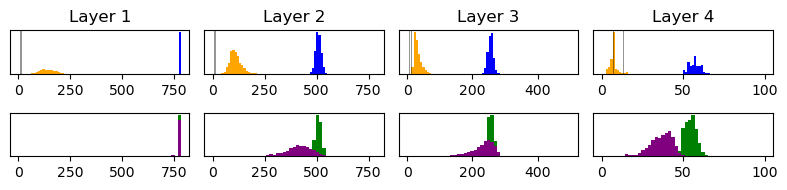

In [11]:
fig, ax = plt.subplots(2,len(out_code.T),figsize=(8,2))

for i in range(len(out_code.T)):
    ax[0,i].hist(out_code[:,i],np.linspace(0,min(layer_sizes[i],784),75),
                                  color='blue',density=True)
    ax[0,i].hist(out_code_post[:,i],np.linspace(0,min(layer_sizes[i],784),75),
                                  color='orange',density=True)
    ylim = ax[0,i].get_ylim()
    ax[0,i].vlines([7,13],[0,0],[1,1],'k',lw=0.4,alpha=0.75)
    ax[0,i].set_ylim(ylim)
    ax[0,i].set_yticks([])
    

    ax[0,i].set_title("Layer " + str(i+1))

    ax[1,i].hist(out_code_pre_rand[:,i],np.linspace(0,min(layer_sizes[i],784),50),
                                  color='green',density=True)
    ax[1,i].hist(out_code_rand[:,i],np.linspace(0,min(layer_sizes[i],784),50),
                                  color='purple',density=True)
    ax[1,i].set_yticks([])
fig.tight_layout()
fig.savefig("../MNIST_code_hist.png",dpi=500)

## Regression problem

In [3]:
from test_functions import *
from torch.utils.data import Dataset, TensorDataset

functions = OptFunctions(10000,2)

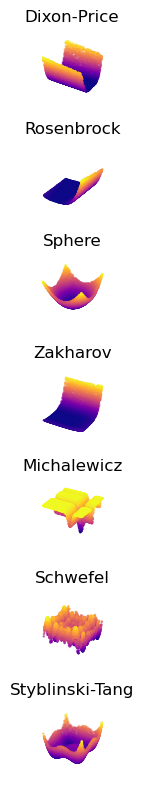

In [13]:
all_functions = [(method_name,method) for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
function_names = ['Dixon-Price','Rosenbrock','Sphere','Zakharov','Michalewicz','Schwefel','Styblinski-Tang']

fig, axs = plt.subplots(len(all_functions),1,figsize=(16,8),subplot_kw={'projection': '3d'})

for i in range(len(all_functions)):
    x, f_x = all_functions[i][1](functions)

    axs[i].scatter(x[0], x[1], f_x, c=f_x, cmap='plasma',s=0.5) 
    
    axs[i].axis('off')
    axs[i].set_title(function_names[i])
fig.tight_layout()
#fig.savefig("../opt_functions.png",dpi=500,transparent=True)

In [17]:
discrete = True
f_dim = 20
n_samples = 10000
opt_functions = OptFunctions(n_samples,f_dim,discretize=discrete,z_score=True)
callable_methods = [method for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
criterion_reg = nn.MSELoss()

pretrained_codewords = []
postrained_codewords = []

for func in callable_methods:
    x_train, f_train = func(opt_functions)
    x_test, f_test = func(opt_functions)
    
    x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
    f_train, f_test = torch.tensor(f_train, dtype=torch.float32), torch.tensor(f_test, dtype=torch.float32)

    reg_data_train = TensorDataset(x_train.T, f_train)
    reg_data_test = TensorDataset(x_test.T, f_test)
    trainloader_reg = torch.utils.data.DataLoader(reg_data_train, batch_size=64, shuffle=True)
    testloader_reg = torch.utils.data.DataLoader(reg_data_test, batch_size=64, shuffle=True)

    model_reg = FeedforwardNetwork(input_size=f_dim,hidden_sizes=[8*f_dim,4*f_dim,2*f_dim],#8*f_dim,4*f_dim,2*f_dim], 
                               out_layer_sz=1, init_type='none',activation=nn.ReLU())

    #out_reg_code = np.zeros([len(x_test.T),3])
    #for i, x_i in enumerate(x_test.T):
    #    out_reg_code[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
    out_reg = model_reg(x_test.T)
    out_reg_code = [torch.sum(out_reg[i]>0,axis=1) for i in range(len(out_reg))]
    pretrained_codewords.append(out_reg_code)

    if discrete:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)
    else:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.0001)
        
    num_epochs = 1000
    loss_hist = []
    for epoch in range(num_epochs):
        for inputs, targets in trainloader_reg:
            # Forward pass
            outputs = model_reg(inputs)[-1]
            loss = criterion_reg(outputs, targets.unsqueeze(1))
    
            # Backward pass and optimization
            optimizer_reg.zero_grad()
            loss.backward()
            optimizer_reg.step()
            loss_hist.append(loss.item())
    
        if (epoch+1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    model_reg.eval()
    with torch.no_grad():
        out_reg_trained = model_reg(x_test.T)
    out_reg_code_trained = [torch.sum(out_reg_trained[i]>0,axis=1) for i in range(len(out_reg_trained))]
    #out_reg_code_trained = np.zeros([len(x_test.T),3])
    #for i, x_i in enumerate(x_test.T):
    #    out_reg_code_trained[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
    postrained_codewords.append(out_reg_code_trained)


Epoch [500/1000], Loss: 0.0011
Epoch [1000/1000], Loss: 0.0019
Epoch [500/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0693
Epoch [500/1000], Loss: 0.0202
Epoch [1000/1000], Loss: 0.0089
Epoch [500/1000], Loss: 0.0037
Epoch [1000/1000], Loss: 0.0033


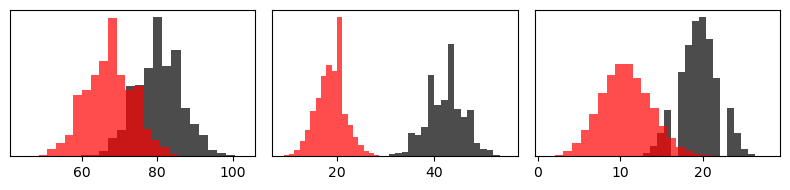

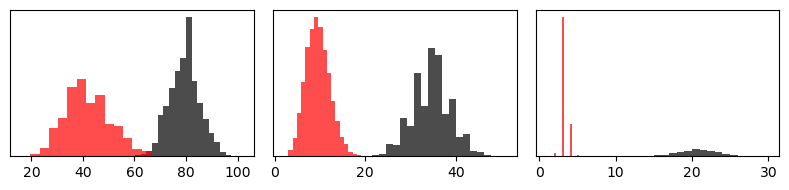

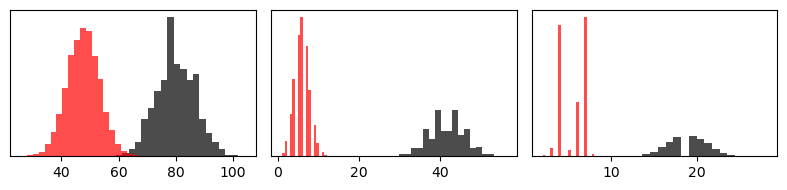

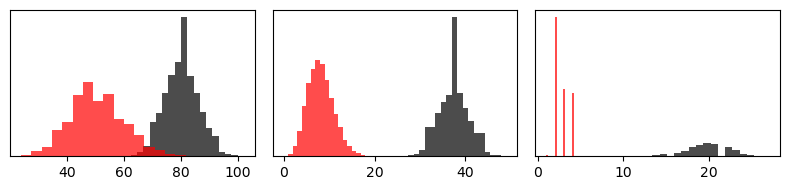

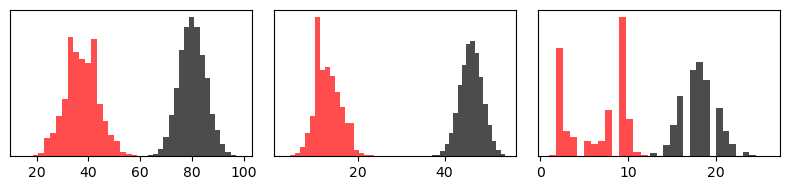

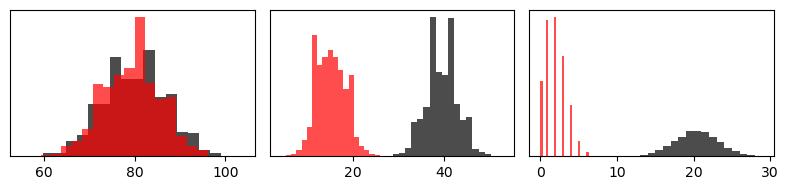

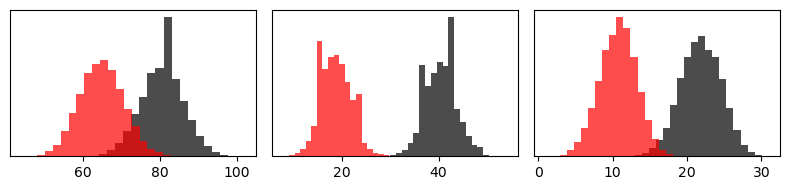

In [20]:
color_hists = ['black','red']

for n,fnames in enumerate(function_names):
    fig, ax = plt.subplots(1,len(out_reg_code)-1,figsize=(8,2))

    for i in range(len(out_reg_code)-1):
        ax[i].hist(pretrained_codewords[n][i],20,#np.linspace(0,f_dim,20),
                                      color=color_hists[0],density=True,alpha=0.7)
        ax[i].hist(postrained_codewords[n][i],20,#np.linspace(0,f_dim,20),
                                          color=color_hists[1],density=True,alpha=0.7)
        ax[i].set_yticks([])
    fig.tight_layout()
    
    if discrete:
        fig.savefig("../"+fnames+"_discrete_hist.png", dpi=500,transparent=True)
    else:
        fig.savefig("../"+fnames+"_continuous_hist.png", dpi=500,transparent=True)

In [10]:
#Example of increasingly smooth functions
dim = 2
n_samples = 10000
n_funcs = 14
x,funct = OptFunctions(n_samples,dim).sphere()#lambda x: np.sum([np.polynomial.legendre.Legendre([0] * 3 + [1])(y) for y in x],0)
functions = gen_classif_functions(funct,n_functions=n_funcs).T[[0,1,2,3,6,12]]
n_funcs = len(functions)+1

In [13]:
np.unique(functions[-2])

array([-1.52752523, -1.09108945, -0.65465367, -0.21821789,  0.21821789,
        0.65465367,  1.09108945,  1.52752523])

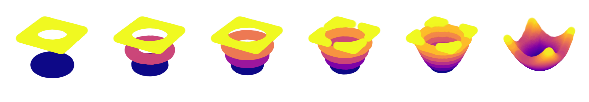

In [11]:
#Plot the functions
fig, ax = plt.subplots(1,n_funcs-1,figsize=(n_funcs-1,2),subplot_kw={'projection': '3d'})
for i in range(n_funcs-1):
    ax[i].scatter(x[0],x[1],functions[i],c=functions[i],cmap='plasma')
    ax[i].axis('off')
fig.tight_layout()
fig.savefig("/Users/kosio/Figures/MfldClassification/disc_functs.png",dpi=500, transparent=True)

In [6]:
# training on increasingly smooth functions
dim = 20
n_reps = 10
n_samples = 10000
pretrained_codewords = np.zeros([n_reps,n_funcs-1,int(n_samples*0.5)])
postrained_codewords = np.zeros([n_reps,n_funcs-1,int(n_samples*0.5)])
criterion_reg = nn.MSELoss()
for nr in range(n_reps):
    #x = np.random.uniform(-1,1,[dim,n_samples])
    x,funct = OptFunctions(n_samples,dim).sphere()#lambda x: np.sum([np.polynomial.legendre.Legendre([0] * 3 + [1])(y) for y in x],0)
    functions = gen_classif_functions(funct,n_functions=n_funcs).T
    
    for n, func in enumerate(functions):
        train_set = np.random.choice(np.arange(0,n_samples),replace=False,size = int(0.5*n_samples))
        test_set = np.setdiff1d(np.arange(0,n_samples), train_set)
        x_train = x[:,train_set]
        x_test = x[:,test_set]
        f_train = func[train_set]
        f_test = func[test_set]
        
        x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
        f_train, f_test = torch.tensor(f_train, dtype=torch.float32), torch.tensor(f_test, dtype=torch.float32)
    
        reg_data_train = TensorDataset(x_train.T, f_train)
        reg_data_test = TensorDataset(x_test.T, f_test)
        trainloader_reg = torch.utils.data.DataLoader(reg_data_train, batch_size=64, shuffle=True)
        testloader_reg = torch.utils.data.DataLoader(reg_data_test, batch_size=64, shuffle=True)
    
        model_reg = FeedforwardNetwork(input_size=dim,hidden_sizes=[8*dim,4*dim,2*dim],
                                   out_layer_sz=1, init_type='none',activation=nn.ReLU())
    
        out_reg_code = np.zeros([len(x_test.T),3])
        #for i, x_i in enumerate(x_test.T):
        #    out_reg_code[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
        out_reg = model_reg(x_test.T)
        out_reg_code = [torch.sum(out_reg[i]>0,axis=1) for i in range(len(out_reg))]
        pretrained_codewords[nr,n] = out_reg_code[-2]
    
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)
            
        num_epochs = 1000
        loss_hist = []
        for epoch in range(num_epochs):
            for inputs, targets in trainloader_reg:
                # Forward pass
                outputs = model_reg(inputs)[-1]
                loss = criterion_reg(outputs, targets.unsqueeze(1))
        
                # Backward pass and optimization
                optimizer_reg.zero_grad()
                loss.backward()
                optimizer_reg.step()
                loss_hist.append(loss.item())
        
            if (epoch+1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        model_reg.eval()
        with torch.no_grad():
            out_reg_trained = model_reg(x_test.T)
        out_reg_code_trained = [torch.sum(out_reg_trained[i]>0,axis=1) for i in range(len(out_reg_trained))]
        #out_reg_code_trained = np.zeros([len(x_test.T),3])
        #for i, x_i in enumerate(x_test.T):
        #    out_reg_code_trained[i,:] = model_reg.compute_rank_at_point(x_i)[:-1]
        postrained_codewords[nr,n] = out_reg_code_trained[-2]

Epoch [500/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0069
Epoch [500/1000], Loss: 0.0007
Epoch [1000/1000], Loss: 0.0002
Epoch [500/1000], Loss: 0.0060
Epoch [1000/1000], Loss: 0.0020
Epoch [500/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0033
Epoch [500/1000], Loss: 0.0042
Epoch [1000/1000], Loss: 0.0013
Epoch [500/1000], Loss: 0.0036
Epoch [1000/1000], Loss: 0.0007


/Users/kosio/Repos/top-mfld-class/src/test_functions.py:94: RuntimeWarning: invalid value encountered in divide
  new_functions[:,n] = (new_functions[:,n]-np.mean(new_functions[:,n]))/np.std(new_functions[:,n])


Epoch [500/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0064
Epoch [1000/1000], Loss: 0.0015
Epoch [500/1000], Loss: 0.0021
Epoch [1000/1000], Loss: 0.0016
Epoch [500/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0025
Epoch [500/1000], Loss: 0.0029
Epoch [1000/1000], Loss: 0.0010
Epoch [500/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0003
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0025
Epoch [1000/1000], Loss: 0.0018
Epoch [500/1000], Loss: 0.0022
Epoch [1000/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0026
Epoch [1000/1000], Loss: 0.0018
Epoch [500/1000], Loss: 0.0012
Epoch [1000/1000], Loss: 0.0017
Epoch [500/1000], Loss: 0.4502
Epoch [1000/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0011
Epoch [1000/1000], Loss: 0.0072
Epoch [500/1000], Loss: 0.0081
Epoch [1000/1000], Loss: 0.0043
Epoch [500/1000], Loss: 0.0060
Epoch [1000/1000], Loss:

In [54]:
from scipy.stats import ranksums
pval = 0.001/len(pretrained_codewords[0,:,0])
significance = np.zeros(len(pretrained_codewords[0,:,0]))
for i in range(len(pretrained_codewords[0,:,0])):
    significance[i] = ranksums(np.mean(pretrained_codewords,2)[:,i],np.mean(postrained_codewords,2)[:,i])[1]<pval

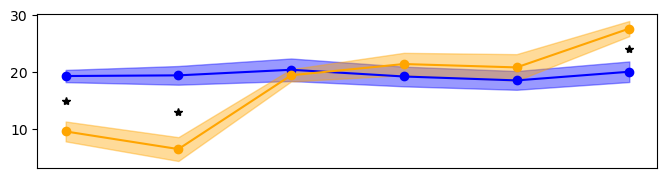

In [65]:
mean_code_pre = np.mean(np.mean(pretrained_codewords,2),0)
mean_code_post = np.mean(np.mean(postrained_codewords,2),0)

std_code_pre = np.std(np.mean(pretrained_codewords,2),0)
std_code_post = np.std(np.mean(postrained_codewords,2),0)

plt.figure(figsize=(8,2))
plt.plot(np.arange(0,n_funcs-1),mean_code_pre,'b-o')
plt.fill_between(np.arange(0,n_funcs-1),mean_code_pre-std_code_pre,mean_code_pre+std_code_pre,alpha=0.4,color='blue')
plt.plot(np.arange(0,n_funcs-1),mean_code_post,'-o',color='orange')
plt.fill_between(np.arange(0,n_funcs-1),mean_code_post-std_code_post,mean_code_post+std_code_post,alpha=0.4,color='orange')
plt.plot(np.where(significance)[0],[15,13,24],'k*')
plt.xticks([])
plt.savefig("/Users/kosio/Figures/MfldClassification/rank_smoothness.png",dpi=500, transparent=True)